In [1]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
from skimage import io
from tqdm.notebook import tqdm, trange

sc.settings.verbosity = 3

import matplotlib
from matplotlib import cm, colors
from matplotlib.pyplot import rc_context

sc.set_figure_params(format="png")
import anndata as ad
import seaborn as sns
from PIL import Image
from scipy import ndimage
from skimage import exposure, measure, morphology
from sklearn.cluster import MiniBatchKMeans
import math
import cv2
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)


In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

In [4]:
donors = [
    "LN Donor A",
    "LN Donor E",
    "INT Donor B",
    "INT Donor E",
    "TS Donor A",
    "TS Donor E",
]


In [5]:
# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition =  name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


In [6]:
marker = 'COL1'
imgs_col = []

# Read COL1 images
for donor in donors:
    path = p_dir / "data" / "whole_stitched"/ donor / f"{marker}.tif"
    
    img = skimage.io.imread(path)

    # img_col= contrast_streching(img)
    img_col = img
    if donor == 'INT Donor B':
        img_col = img_col[:5000, :]
    imgs_col.append(img_col)

In [7]:
# Read single-cell data
adata_path = data_dir / "metadata" / f"combined_semi_final.h5ad"
# adata_path = data_dir / "metadata" / f"combined_flowjo.h5ad"
adata = sc.read_h5ad(adata_path)

# Get follicle masks
masks_follicle = get_masks(data_dir / 'masks_follicle')


In [8]:
adata_folls = []

for i in range(len(donors)):
    # Read follicle info
    path = data_path = data_dir / "follicle" / f"{donors[i]}.csv"
    df = pd.read_csv(path)
    df = df[df.area > 1000]
                   
    # Get donor adata
    adata_donor = adata[adata.obs.Dataset == donors[i]]
    X_spatial = np.array(adata_donor.obsm['spatial'])[:, [1,0]]

    # Read mask
    mask_follicle = masks_follicle[donors[i]]

    # Read COl and cluster img
    img_col = imgs_col[i]
    
    # Append mask follicle to match size of img
    mask_follicle = cv2.copyMakeBorder(mask_follicle, 0, max(0, img_col.shape[0]-mask_follicle.shape[0]), 
                                       0, max(0, img_col.shape[1]-mask_follicle.shape[1]), cv2.BORDER_CONSTANT, None, value = 0)

    for row in tqdm(df.itertuples(), total=len(df)):
        # Get mask
        mask = mask_follicle == row.Region_label

        # Get cell indices in mask
        in_mask = mask[tuple(X_spatial.astype(int).T)]
        adata_foll = adata_donor[in_mask].copy()
        coords =  np.array(adata_foll.obsm['spatial'])[:, [1,0]]

        adata_foll.obs['Foll'] = row.Region_label

        adata_folls.append(adata_foll)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

In [9]:
adata = ad.concat(adata_folls)

# Bar plot

In [10]:
df = adata.obs

In [11]:
df.groupby(['Dataset', 'Foll'], as_index=False)['Phenotype'].value_counts().to_clipboard()

In [16]:
df['Tissue'] = df['Dataset'].str.split(' ').str[0]

In [24]:
df_melt = df.groupby(['Tissue'], as_index=False)['Phenotype'].value_counts()

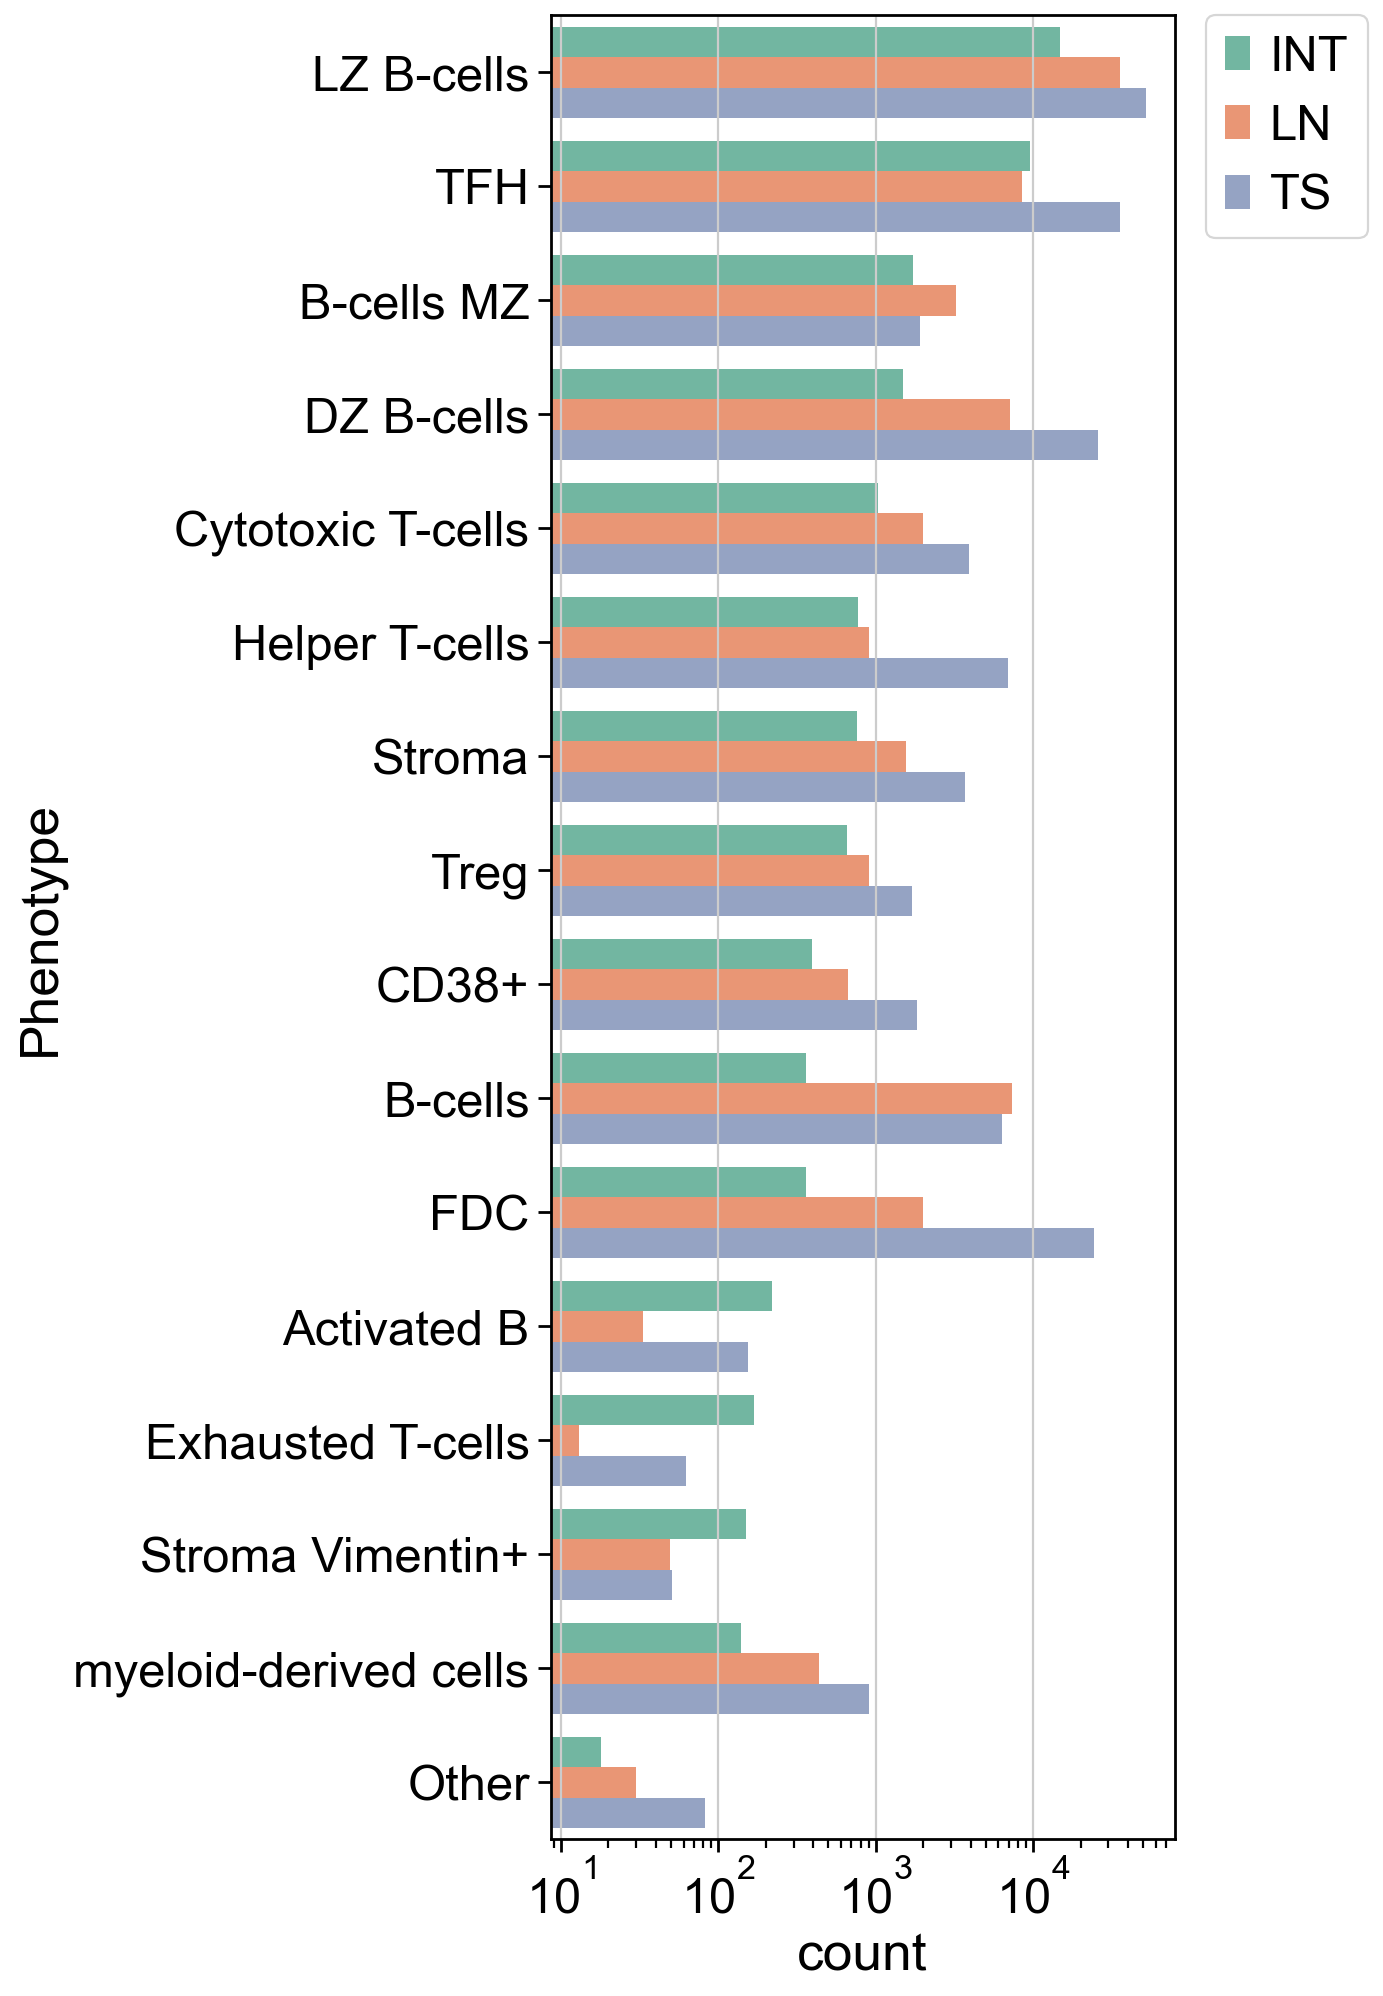

In [38]:
with sns.plotting_context('notebook', font_scale=2):
    fig, ax = plt.subplots(figsize=(5, 15))
    sns.barplot(df_melt, y='Phenotype', x='count', hue='Tissue', palette='Set2',
               ax=ax)
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    ax.set_xscale("log")

# Chord plot

In [40]:
import spatial as sm

In [41]:
# Spatial LDA need centroid info as indivisual obs
adata.obs['X_centroid'] = adata.obsm['spatial'][:,0]
adata.obs['Y_centroid'] = adata.obsm['spatial'][:,1]
adata.obs = adata.obs.reset_index(drop=True)

In [44]:
import matplotlib 

# Get adata 
phenotype_name = 'Phenotype'
adata.obs[phenotype_name] = adata.obs[phenotype_name].astype('category')

sc.tl.dendrogram(adata, groupby=phenotype_name)

adata.uns["New_colors"] = sc.pl.palettes.vega_20_scanpy[:len(np.unique(adata.obs[phenotype_name]))]
cluster_label_order = adata.uns[f'dendrogram_{phenotype_name}']['categories_ordered']

# Define colormap
colors = adata.uns["New_colors"]
labels = adata.obs[phenotype_name].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)
colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Phenotype']`


In [45]:
from mne_connectivity.viz import plot_connectivity_circle
from mne.viz import circular_layout

['LN Donor A', 'LN Donor E']
Processing Image: ['LN Donor A']
Identifying neighbours within 20 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['LN Donor E']
Identifying neighbours within 20 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\thu71\AppData\Local\Temp\ipykernel_7304\754917271.py:30: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stacked = stacked.groupby(['phenotype', 'neighbour_phenotype']).mean().reset_index()
C:\Users\thu71\AppData\Local\Temp\ipykernel_7304\754917271.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, 

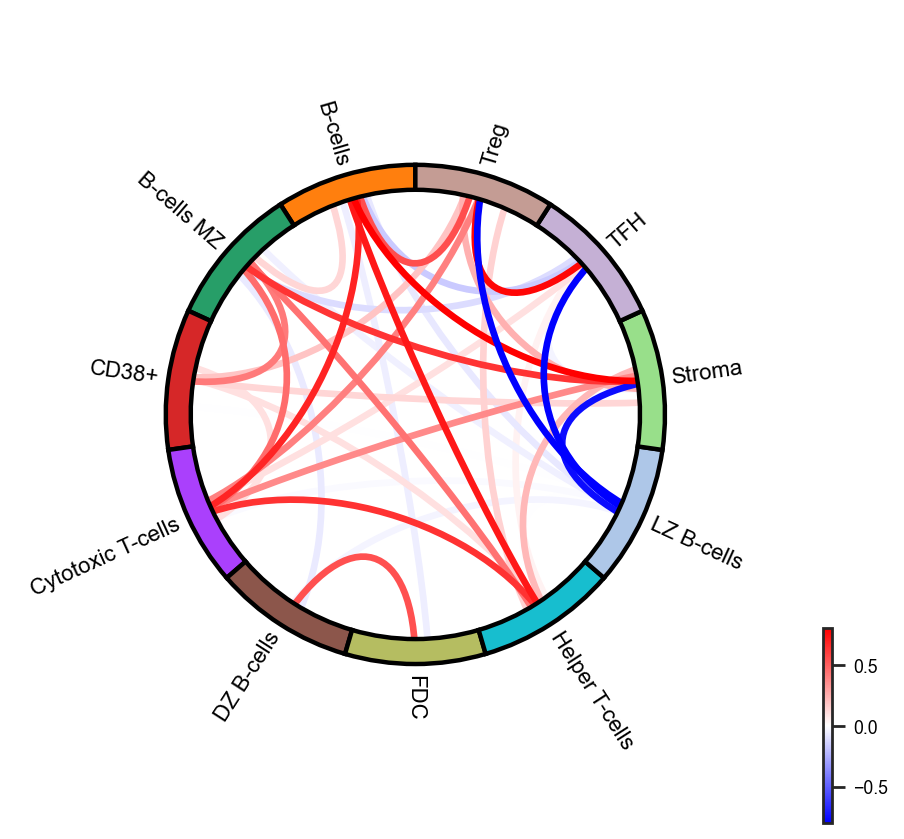

['TS Donor A', 'TS Donor E']
Processing Image: ['TS Donor A']
Identifying neighbours within 20 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['TS Donor E']
Identifying neighbours within 20 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\thu71\AppData\Local\Temp\ipykernel_7304\754917271.py:30: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stacked = stacked.groupby(['phenotype', 'neighbour_phenotype']).mean().reset_index()
C:\Users\thu71\AppData\Local\Temp\ipykernel_7304\754917271.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, 

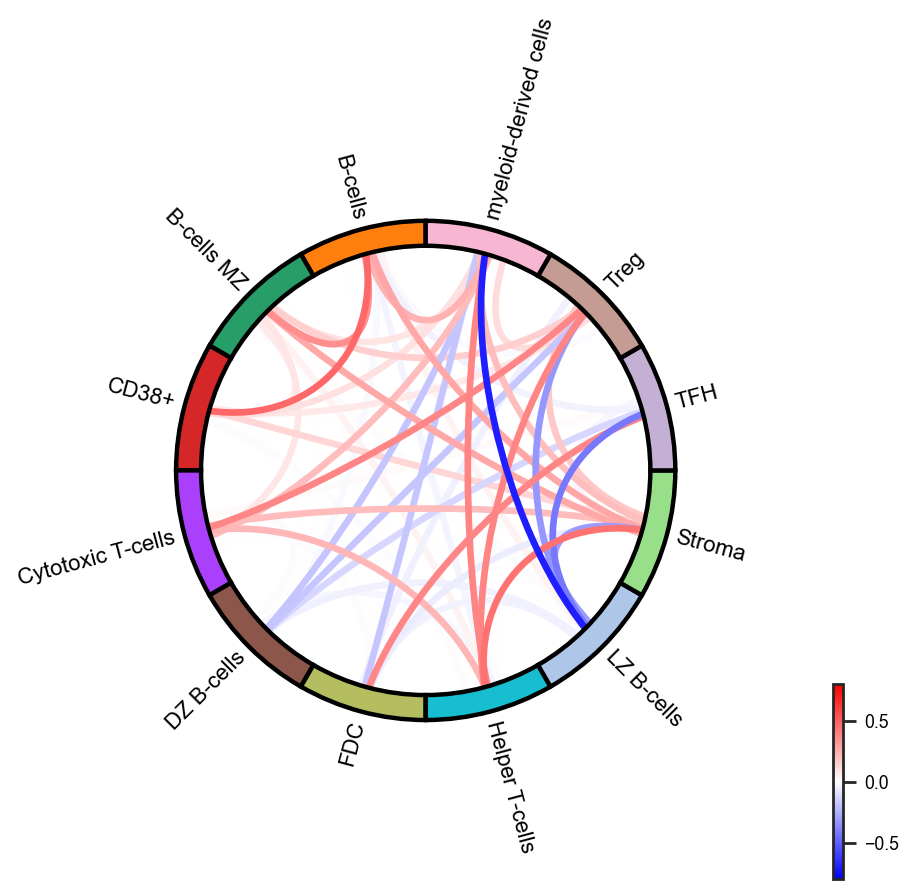

['INT Donor B', 'INT Donor E']
Processing Image: ['INT Donor B']
Identifying neighbours within 20 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['INT Donor E']
Identifying neighbours within 20 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\thu71\AppData\Local\Temp\ipykernel_7304\754917271.py:30: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stacked = stacked.groupby(['phenotype', 'neighbour_phenotype']).mean().reset_index()
C:\Users\thu71\AppData\Local\Temp\ipykernel_7304\754917271.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, 

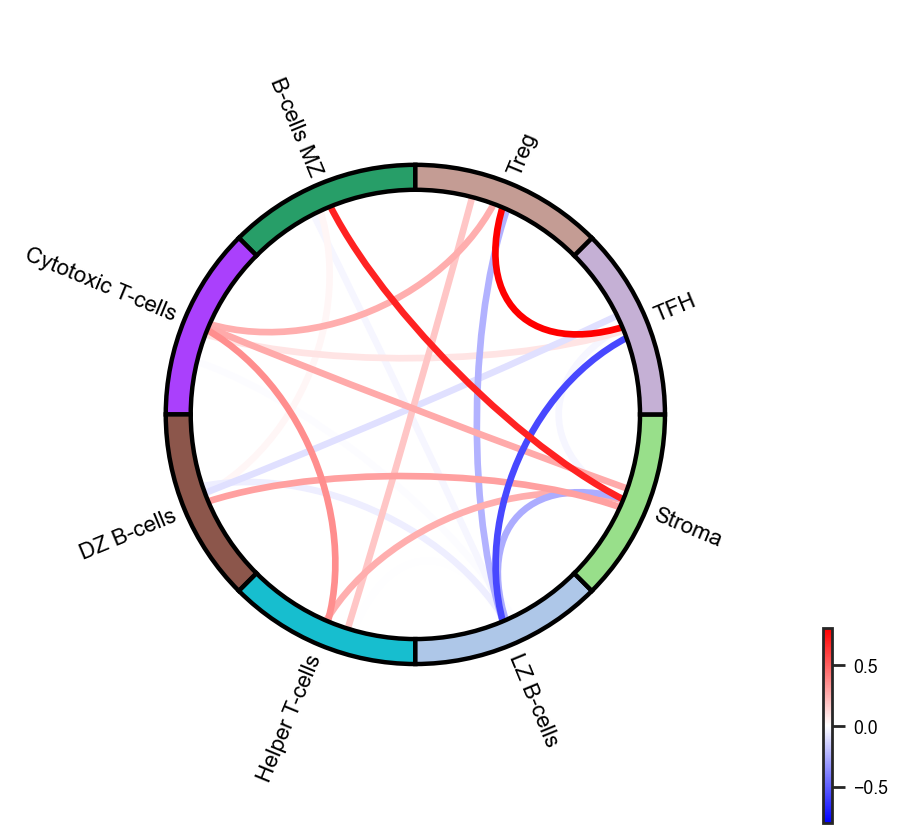

In [47]:
var =  'Phenotype'
tissues = [['LN Donor A', 'LN Donor E'], 
           ['TS Donor A', 'TS Donor E'],
           ['INT Donor B', 'INT Donor E']]

for d in tissues:
    print(d)
    adata_subset = adata[adata.obs.Dataset.isin(d), :]
    counts = adata_subset.obs[var].value_counts()
    low_counts = counts[counts < 500].index.tolist()
    adata_subset = adata_subset[~adata_subset.obs[var].isin(low_counts)]
    
    # Plot interaction p value 
    with sns.plotting_context('talk', font_scale=1.2):
        adata_subset = sm.tl.spatial_interaction(adata_subset,
                                             method='radius', 
                                             radius=20, 
                                             knn=15,
                                             phenotype=var,
                                             imageid='Dataset',
                                             x_coordinate='X_centroid',
                                             y_coordinate='Y_centroid')
    # Get neighboring score and p values
    adata_subset.uns['spatial_interaction'].columns
    spatial_score = adata_subset.uns['spatial_interaction'].iloc[:,[0,1,2,4]]
    p_value = adata_subset.uns['spatial_interaction'].iloc[:,[0,1,3,5]]

    stacked = spatial_score.set_index(['phenotype', 'neighbour_phenotype']).stack().reset_index()
    stacked.columns = ['phenotype', 'neighbour_phenotype', 'Tissue', 'Score']
    stacked = stacked.groupby(['phenotype', 'neighbour_phenotype']).mean().reset_index()
    score_matrix = stacked.pivot_table(index='phenotype', columns='neighbour_phenotype', values=['Score'])

    stacked = p_value.set_index(['phenotype', 'neighbour_phenotype']).stack().reset_index()
    stacked.columns = ['phenotype', 'neighbour_phenotype', 'Tissue', 'Score']
    stacked = stacked.groupby(['phenotype', 'neighbour_phenotype']).mean().reset_index()
    p_matrix = stacked.pivot_table(index='phenotype', columns='neighbour_phenotype', values=['Score'])

    # Create link matrix info
    node_names = score_matrix.index.tolist()
    con = score_matrix.values
    con = np.where(p_matrix.values < 0.0005, con, np.nan)

    # Plot chord plot
    label_colors = c=np.array([colors_rgb_dict[i]/255 for i in node_names])
    node_angles = circular_layout(node_names, node_names)

    fig, axes = plot_connectivity_circle(con, node_names, colormap='bwr', linewidth=3, 
                                         fontsize_names = 10,facecolor='white', textcolor='black',
                                          node_angles=node_angles, node_colors=label_colors, vmin=-0.8, vmax=0.8) 
